RNN으로 여행자 수 예측하기 2022년 1월 10일 김이룸

In [ ]:
# Importing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Dense, LSTM, InputLayer, SimpleRNN
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
# Setting

MY_PAST = 3     # 입력 수
MY_SPLIT = 0.8  # train_size = 0.8
MY_HIDDEN = 300
MY_SHAPE = (MY_PAST, 1)
MY_EPOCH = 300            # 반복 학습 수

(144, 1)
     1
0  112
1  118
2  132
3  129
4  121
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


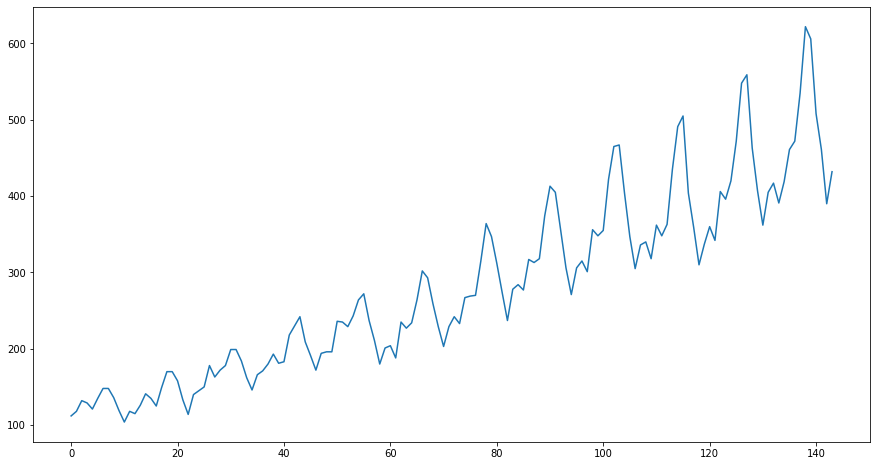

In [ ]:
# Loading
path = '/content/drive/MyDrive/my-data/airline.csv'
data = pd.read_csv(path,
                   header=None,
                   usecols=[1])

# print sample
print(data.shape)
print(data.head())
print(data.describe())

# plot smaple
plt.figure(figsize=(15,8))
plt.plot(data)

(144, 1)
          0
0  0.015444
1  0.027027
2  0.054054
3  0.048263
4  0.032819
                0
count  144.000000
mean     0.340345
std      0.231595
min      0.000000
25%      0.146718
50%      0.311776
75%      0.495174
max      1.000000


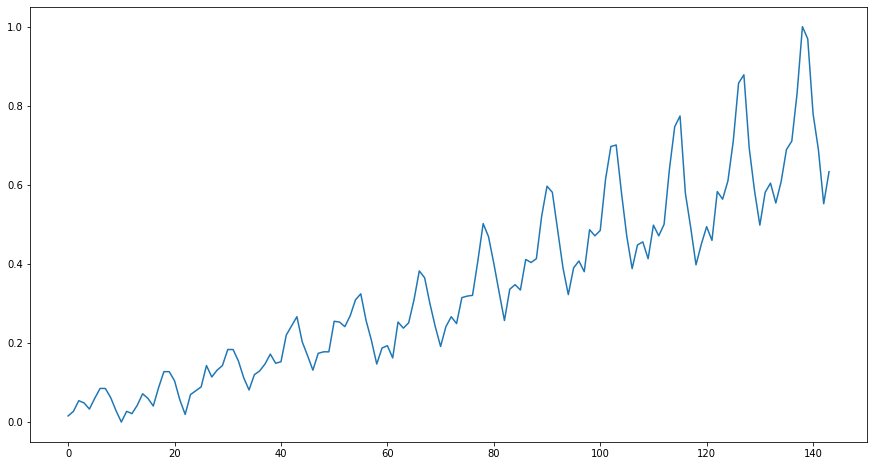

In [ ]:
# Scalling

scaler = MinMaxScaler()
m_data = scaler.fit_transform(data)

# print(type(m_data))
m_data = pd.DataFrame(m_data)

# print smaple
print(m_data.shape)
print(m_data.head())
print(m_data.describe())

# plot sample : 모양은 data plot과 다를게 없다, but y-axis 스케일이 축소됨을 알 수 있다.
plt.figure(figsize=(15,8))
plt.plot(m_data)

In [ ]:
# 분할 묶음 코드에서 m_data가 1차원임을 가정하고 있기에 삽입한 코드 -> 
m_data = np.array(m_data) 
# m_data = m_data.flatten() # flatten 사용하면 split 모양이 2차원으로 된다. 사용하면 안된다. split은 3차원이여야 한다.


# Splitting 
# 시계열 데이터 분할 묶음 - 옵션 2 : 한단씩 미루고 묶기
# 현재 입력 수(MY_PAST)를 3으로 hyperparameter 지정했다.
# 묶음(가래떡)의 수 계산 방법 : 전체 데이터 수 - 입력 수 
# 위 계산을 현 상황에 적용해보면 :
#   144 - 3 = 141
# 즉, size - MY_PAST = 141 이다. 이는 이 데이터로 생성한 총 묶음 수이다.
# i + MY_PAST + 1 : 한닥씩 미루어 묶음을 생성하기 위해 1을 더했다.
split=[]
size = len(m_data)
print('데이터 수 : ', size)

for i in range(size - MY_PAST):
  split.append(m_data[i: i + MY_PAST + 1])


print(m_data[:5])
print(split[0])



print(m_data[1:5].flatten())
print(split[1].flatten())


데이터 수 :  144
[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]
[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.02702703 0.05405405 0.04826255 0.03281853]


In [ ]:
print(type(split))
split = np.array(split)
print(type(split))
print(split.shape) # 모양의 구체적인 형태는 Day5 판서를 참고하시오.

<class 'list'>
<class 'numpy.ndarray'>
(141, 4, 1)


In [ ]:
X_data = split[0:142, :MY_PAST]
# X_data[0]
Y_data = split[:, -1]
# Y_data[1]

print('입력 데이터 모양 : ',X_data.shape) 
print('출력 데이터 모양 : ',Y_data.shape)

입력 데이터 모양 :  (141, 3, 1)
출력 데이터 모양 :  (141, 1)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    train_size=MY_SPLIT,
                                                    shuffle=False)

print('학습용 입력 데이터 모양 : ', X_train.shape)
print('학습용 출력 데이터 모양 : ', Y_train.shape)
print('평가용 입력 데이터 모양 : ', X_test.shape)
print('평가용 출력 데이터 모양 : ', Y_test.shape)

학습용 입력 데이터 모양 :  (112, 3, 1)
학습용 출력 데이터 모양 :  (112, 1)
평가용 입력 데이터 모양 :  (29, 3, 1)
평가용 출력 데이터 모양 :  (29, 1)


In [ ]:
# RNN 구현 : 설계도를 참고하시오.

model = Sequential()

# 입력층 add 
# input_shape : 입력데이터 하나의 모양 : MY_SAHPE
model.add(InputLayer(input_shape=MY_SHAPE))

# RNN 셀 add 
# units : 다음단으로 넘기는 숫자 개수
model.add(SimpleRNN(units=MY_HIDDEN))

# 출력층 add
# sigmoid : 주어진 입력 데이터를 [0,1] 사이의 숫자로 전환한다. [0,1] 안의 확률값으로 바꿔준다.
# 여행자 수 예측하는데 왜 sigmoid 활성화함수를 사용하는가?
#  답 : MinMax 스케일링을했기 때문에 학습 데이터가 모두 [0,1] 안에 있다. 예측하는 수도 [0,1] 사이 값이여야한다.(핵심)
# units : 출력층 뉴런 개수
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 300)               90600     
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 90,901
Trainable params: 90,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# RNN 학습

model.compile(optimizer='adam',
              loss='mse')

# RNN 학습 진행
# verbose=0 : 반복 학습할 진행도 출력 끄기 -> 끄면 학습 시간 단축효과 있음
# verbose=1 : 반복 학습할 진행도 출력 켜기
print('학습시작')
begin = time()

model.fit(X_train,
          Y_train,
          epochs=MY_EPOCH,
          verbose=1)

end = time()
print('총 학습 시간 : ', end - begin)

학습시작
Epoch 1/300
4/4 [==============================] - 1s 8ms/step - loss: 0.0685
Epoch 2/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0644
Epoch 3/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0533
Epoch 4/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0390
Epoch 5/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 6/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 7/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 8/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 9/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 10/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 11/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 12/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 13/300
4/4 [==============================] - 0s 

In [ ]:
# RNN 평가

score = model.evaluate(X_test,
                       Y_test)

print('최종 mse loos 값 : ',score) 

1/1 [==============================] - 0s 211ms/step - loss: 0.0119
최종 mse loos 값 :  0.011921344324946404


[0.730591]
[0.77413127]


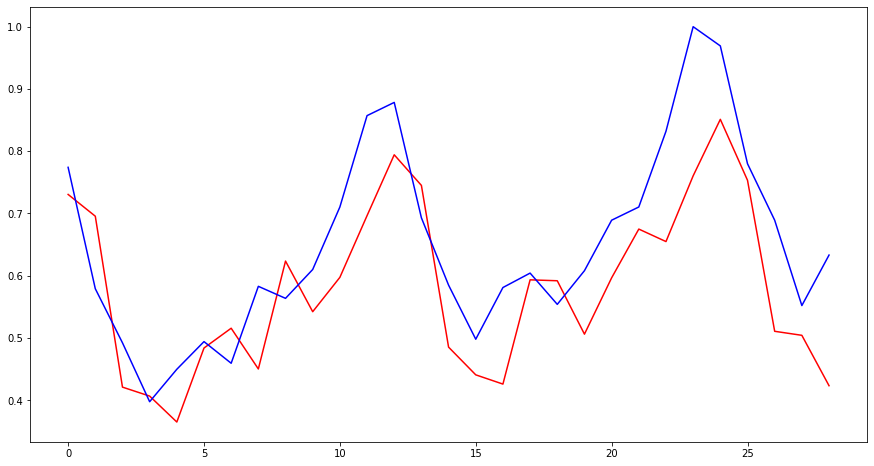

In [ ]:
# RNN 예측

pred = model.predict(X_test)

# print(pred.shape)
print(pred[0])
print(Y_test[0])

plt.figure(figsize=(15,8))
plt.plot(pred, 'r')   # mae를 쓰면 학습이 전혀 안된다.
plt.plot(Y_test, 'b') # 원본 data 뒤 20%  그래프를 확대해서 보고 있는 것이다.  원본 plot 확인해보면 개형이 유사함을 확인할 수 있다.


In [ ]:
# 데이터 역전환 : 정규화 된 데이터([0,1])를 원본으로 전환 -> 얼마나 틀렸는지 직접 확인하기 위함

# print(pred.shape)
print(pred.flatten())
pred = scaler.inverse_transform(pred) # 예측값을 원본으로 돌리기 
tmp = scaler.inverse_transform(Y_test) # 임시변수 tmp에 평가용 출력 데이터를 원래 값으로 역전환.

# 첫번째 평가용 문제 비교
print('예측값 : ', pred[0])
print('정답 : ', tmp[0]) # 정확하지는 앉지만 대략 맞다.

[0.730591   0.69563854 0.42113093 0.4067303  0.36505732 0.4839163
 0.5157131  0.45029604 0.62356204 0.54225767 0.59742045 0.6965033
 0.79425293 0.7450975  0.48536468 0.44085044 0.42599878 0.5934361
 0.5919533  0.50619876 0.5966429  0.67495286 0.6548907  0.76046044
 0.8512017  0.75333726 0.5107857  0.5043251  0.42339927]
예측값 :  [482.44614]
정답 :  [505.]
